# Artificial Neural Networks & TensorFlow

**[Michiel Stock](michiel.stock@ugent.be)** 

*Predictive Modelling*

November 2016

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from IPython.core.display import HTML

sns.set_style('white')

## Introduction

### Models seen so far

- Linear models: $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$ (linear regresion, logistic regression, perceptron...)

- Non-linear models by feature expansion: $f(\mathbf{x}) = \mathbf{w}^\top \phi(\mathbf{x})$ (regression using basis expansion, SVM, KRR)

- Other nonlinear models (kNN, decision trees...)

### Shallow models

![](Figures/shallowmodels.png)

Shallow models:
- divide feature space in regions
- performance very dependent on quality of features
- feature engineering requires lot of prior knowledge!
- often convex optimization problem or at least stable solution

### Deep models

- iteratively combine low-level features in high-level features
- learn a **hierachical representation** of the data
- model: a *sequence* of parameterized nonlinear transformations of the features
- often huge number of parameters
- challenging to train!
- requires lot's of data

Hierachical model

![](Figures/ANN.png)

Hierarchical structure in **images**

![](Figures/ANNimages.png)

Hierachical structure in **language**

![](Figures/language.jpg)

Hierarchical structure in **biological systems**

![](Figures/Genomics_GTL_Pictorial_Program.jpg)

## Roadmap

Overview theoretical concepts, practical implementation in [TensorFlow](https://www.tensorflow.org/).

1. Illustration of the MNIST dataset
2. Single neuron as classifier
3. Architecture of articial neural networks
4. Training artifical neural networks
5. Regularization and capacity control

### TensorFlow

![](Figures/TensorFlow.jpg)

## The MNIST dataset

- 65000 $28\times 28$ grayscale images of digits
- simple multiclass classification task: label image 0-9 
- popular dataset to compare different learning algorithms
- state-of-the-art performance: $\pm 99.7\%$ accuracy (better than a human!)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print('Number of train images: {}'.format(len(mnist.train.labels)))
print('Number of test images: {}'.format(len(mnist.test.labels)))

Number of train images: 55000
Number of test images: 10000


In [4]:
import random as rd

def show_digits():
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

    for axrow in axes:
        for ax in axrow:
            # choose random image
            i = rd.randint(0, len(mnist.train.labels)-1)
            # plot image
            ax.imshow(mnist.train.images[i, :].reshape((28, 28)))
            ax.set_xticks([])
            ax.set_yticks([])
            # add title
            ax.set_title('example instance nr. {}'.format(mnist.train.labels[i].argmax()))

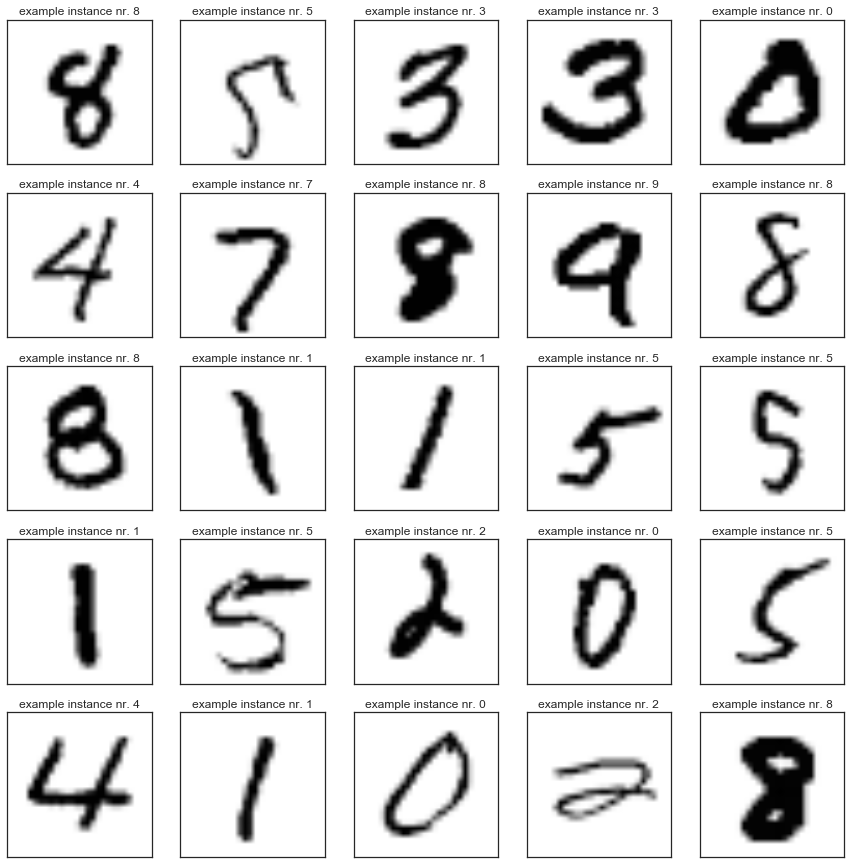

In [5]:
show_digits()

## A single neuron as classifier

## Biological neuron

![](Figures/neuron_anatomy.jpg)

## Abstract neuron

![](Figures/AN.png)

Mathematical model of a neuron:

\begin{align}
f(\mathbf{x}) & = h(\mathbf{w}^\top \mathbf{x} + b)\\
& = h(a)\,
\end{align}
with

- $\mathbf{x}$: the **input** of the artificial neuron
- $f(\mathbf{x})$: the **output** of the artificial neuron
- $\mathbf{w}$: the **weights** of the artificial neuron
- $b$: the **bias** of the artificial neuron
- $a = \mathbf{w}^\top \mathbf{x}$: the **activation** of the artificial neuron
- $h(\cdot)$: a differentiable, nonlinear **activation function**

## Activation functions

| **function** | **formula**           |  **domain** |
|---------|----------------------------------------------------|---|
| linear  | $h(a) = a$                                         | $\mathbb{R}\rightarrow \mathbb{R}$  |
| sigmoid | $h(a) = \frac{a}{1+e^{-a}}$                      | $\mathbb{R}\rightarrow [0,1]$  | 
| tanh    | $h(a) = \frac{e^{a}-e^{-a}}{e^{a}+e^{-a}}$ | $\mathbb{R}\rightarrow [-1,1]$  | 
| ReLu    | $h(a) = \max(0, a)$  | $\mathbb{R}\rightarrow \mathbb{R}^+$|
| softmax | $h(\mathbf{a})_i = \frac{e^{a_i}}{\sum_{j=1}^k e^{a_j}}$|$\mathbb{R}^k\rightarrow \Delta^k$|

In [6]:
def plot_activations():
    x = np.linspace(-4, 4)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    
    col='r'
    
    # linear
    axes[0,0].plot(x, x, label='linear', c=col, lw=3)
    # sigmoid
    axes[0,1].plot(x, 1 / (1 + np.exp(-x)), c=col, label='sigmoid', lw=3)
    # tanh
    axes[1,0].plot(x, np.tanh(x), label='tanh', c=col, lw=3)
    # ReLu
    axes[1,1].plot(x, np.maximum(0, x), label='ReLu', c=col, lw=3)
    axes[1,1].set_ylim([-1, 4])
    
    for ax in [axes[0,0], axes[1,0], axes[0,1], axes[1,1]]: 
        ax.set_ylabel('output')
        ax.set_xlabel(r'$x$')
        ax.legend(loc=0)
        

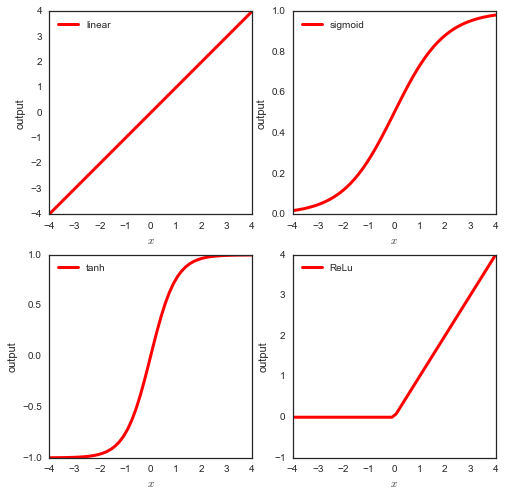

In [7]:
plot_activations()

## Single neuron to classify digits

model:

$$
f(\mathbf{x})_i = h(\mathbf{x}^\top\mathbf{W} +\mathbf{b})\,
$$

with

- $\mathbf{W}$: $(784 \times 10)$ weight matrix (one column for each digit)
- $\mathbf{b}$: $(1 \times 10)$ bias vector
- $h(\cdot)$: softmax activation function

Find optimal $\mathbf{W}$, $\mathbf{b}$ by minimizing **cross entropy**:

$$
\mathcal{L}_i(\mathbf{W}, \mathbf{b}) = -\sum_{i=1}^{10} y_i \log(f(\mathbf{x})_i)
$$

In [8]:
# initialize tensorflow
import tensorflow as tf
sess = tf.InteractiveSession()

In [9]:
# define variables
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [10]:
# definine parameters
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

In [11]:
# initialize
sess.run(tf.initialize_all_variables())

In [12]:
# define model
a = tf.matmul(x, W) + b  # activation
f = tf.nn.softmax(a)  # model

In [13]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(a, y_))

In [14]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [15]:
for i in range(5000):  # train for 5000 stochastic gradient descent steps
    batch = mnist.train.next_batch(100)  # take 100 instances in each step
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

In [16]:
correct_prediction = tf.equal(tf.argmax(a,1), tf.argmax(y_,1))

In [17]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [18]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9226


In [19]:
def show_digits_weights():
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))
    i = 0
    for axrow in axes:
        for ax in axrow:
            # plot image
            ax.imshow(W.eval()[:, i].reshape((28, 28)),
                     interpolation='nearest', cmap='bwr')
            ax.set_xticks([])
            ax.set_yticks([])
            # add title
            ax.set_title('weights class {}'.format(i))
            i += 1

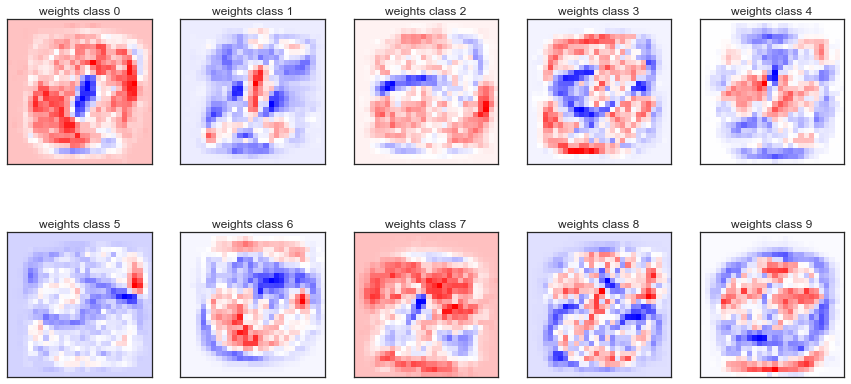

In [20]:
show_digits_weights()

## Architecture of neural networks

One neuron: linear aggreation of inputs and nonlinear processing.

Neurons are combined in an **architecture**.

### Feed-forward neural networks

![](Figures/FFANN.png)

- information flows in one direction
- consists of an **input layer**, one or several **hidden layers** and an **output layer**
- feed-forward ANN of sufficient complexity can approximate any **function**

### Recurrent neural networks

![](Figures/RCANN.png)

- contains self loops
- has **hidden states**
- for processing and generating **sequences**
- a recurrent ANN of sufficient complexity can approximate any **program**
- hard to train (even more than feed-forward ANNs!)

For more information, see [here](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

### Implementing a feed forward ANN with two hidden layers

\begin{align}
\mathbf{z}^{(1)} &= h^1(\mathbf{W}_1\mathbf{x}+\mathbf{b}_1)\\
\mathbf{z}^{(2)} &= h^2(\mathbf{W}_2\mathbf{z}^{(1)}+\mathbf{b}_2)\\
f(\mathbf{x}) &= h^3(\mathbf{W}_3\mathbf{z}^{(2)}+\mathbf{b}_3)
\end{align}

with $h^1(\cdot)$ and $h^2(\cdot)$ $\tanh$ activation functions and $h^3(\cdot)$ the softmax function.

For simplicity: $\boldsymbol{\theta} = (\mathbf{W},\mathbf{b})$.
![](Figures/ANN_example.png)

In [21]:
def weight_variable(shape):
    """
    Generate weight variable
    """
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """
    Generate bias variable
    """
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [22]:
# first layer
n_neurons_1 = 50
W1, b1 = weight_variable([784, n_neurons_1]), bias_variable([n_neurons_1])
a1 = tf.matmul(x, W1) + b1
z1 = tf.tanh(a1)

# second layer
n_neurons_2 = 30
W2, b2 = weight_variable([n_neurons_1, n_neurons_2]), bias_variable([n_neurons_2])
a2 = tf.matmul(z1, W2) + b2
z2 = tf.tanh(a2)

# output layer
W3, b3 = weight_variable([n_neurons_2, 10]), bias_variable([10])
a3 = tf.matmul(z2, W3) + b3
f = tf.nn.softmax(a3)

In [23]:
sess.run(tf.initialize_all_variables())
f.eval(feed_dict={x:mnist.test.images[:10]})

array([[ 0.09580619,  0.09611142,  0.08667248,  0.10455168,  0.09871539,
         0.1017328 ,  0.0963599 ,  0.11979301,  0.10632418,  0.09393305],
       [ 0.10370979,  0.10490365,  0.07299961,  0.07560103,  0.11000773,
         0.09688473,  0.10056177,  0.08620445,  0.09230078,  0.15682645],
       [ 0.10125647,  0.10841426,  0.08616632,  0.07792259,  0.13959356,
         0.08393339,  0.08672092,  0.11258784,  0.09846039,  0.10494427],
       [ 0.10154519,  0.11135967,  0.08142651,  0.08358993,  0.11022423,
         0.0994373 ,  0.08562517,  0.09744484,  0.09422465,  0.13512242],
       [ 0.08691968,  0.09878922,  0.07661698,  0.0984427 ,  0.11771441,
         0.11308458,  0.09792984,  0.10212411,  0.09750921,  0.11086929],
       [ 0.09315032,  0.10587767,  0.08729433,  0.08080371,  0.14780495,
         0.08323544,  0.0910073 ,  0.11714631,  0.09996381,  0.09371629],
       [ 0.08807931,  0.09762579,  0.09449539,  0.09317802,  0.11149953,
         0.10990451,  0.09624353,  0.10055903

In [24]:
# update functions for prediction using new netwoek
correct_prediction = tf.equal(tf.argmax(f,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Training artifical neural networks

Training a statistical model = solving an **optimization** problem:

$$
\min_\boldsymbol{\theta} \sum_{i=1}^n \mathcal{L}_i(y_i, f(\mathbf{x}_i| \boldsymbol{\theta}))\,,
$$

with $\mathcal{L}_i$ a **loss function** over the instances and $\boldsymbol{\theta}$ the parameters of the model.

### Popular loss functions

|    name    |            formula                 |         purpose              | domain |
|---------------|-----------------------------------------------------|-----------------------|----|
| squared loss  | $\mathcal{L}(y,f(\mathbf{x} ))=(y - f(\mathbf{x}))^2$ | regression            | $f(\mathbf{x}) \in \mathbb{R}$ |
| logistic loss | $\mathcal{L}(y,f(\mathbf{x} ))=-y\log(f(\mathbf{x}))-(1-y)\log(1-f(\mathbf{x}))$ | binary classification | $f(\mathbf{x}) \in [0,1]$ |
| cross entropy | $\mathcal{L}(\mathbf{y},\mathbf{f}(\mathbf{x} ) )= -\sum_{j=i}^k y_j\log(f_j(\mathbf{x} ))$ | multiclass classification|$\mathbf{f}(\mathbf{x}) \in \Delta^k$ |

### Steepest gradient descent

Minimizing a function? Just follow the gradient:

$$
\boldsymbol{\theta} := \boldsymbol{\theta} - \eta\nabla_\boldsymbol{\theta} \sum_{i=1}^n \mathcal{L}_i(y_i, f(\mathbf{x}_i| \boldsymbol{\theta}))\,,
$$

with $\nabla_\boldsymbol{\theta}$ the gradient w.r.t. $\boldsymbol{\theta}$ and $\eta$ the **stepsize**.

### Problems with steepest gradient descent

Steepest gradient descent is inefficient!

![](Figures/gradient_descent.png)

Slow convergence for even simple convex problems...

For non-convex problems, steepest gradient descent can get stuck in **local optima** rather than the **global optimum**.

![](Figures/gradient_descent_nonconvex.jpeg)

And artificial neural networks are extremely non-convex...

Solutions and modifications:
- run multiple optimizations with different starting conditions
- use only a small subset of the data in each optimization step (**stochastic gradient descent**)
- better optimization routines: use (an approximation of) the **Hessian**

[Overview](http://sebastianruder.com/optimizing-gradient-descent/) of some gradient descent based algorimthms or follow our course on mathematical optimization!

### Stochastic gradient descent with momentum

Simple, though powerful modification of the gradient descent algorithm: using **momentum**.

Search follows a general direction, determined by the gradient, but is only allowed to change slowly:

\begin{align}
\mathbf{v}&:=\gamma \mathbf{v} + \eta\nabla_\boldsymbol{\theta} \sum_{i=1}^n\mathcal{L}_i(y_i, f(\mathbf{x}_i| \boldsymbol{\theta}))\\
\boldsymbol{\theta} & := \boldsymbol{\theta} - \mathbf{v}\,,
\end{align}

with

- $\mathbf{v}$ the search direction
- $\gamma\in[0, 1]$ the momentum parameter 

### Computing gradients

How do we get $\nabla_\boldsymbol{\theta} \sum_{i=1}^n\mathcal{L}_i(y_i, f(\mathbf{x}_i| \boldsymbol{\theta}))$ (efficiently)?

![](Figures/ANN_example.png)

### Forward propagation

For example, get $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta_1}}$:

![](Figures/Forwardprop.png)

### Backpropagation

Evaluate loss for instance, compute gradients in backwards direction.

![](Figures/Backprop.png)

Then for example:

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_1} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(1)}}\frac{\partial \mathbf{z}^{(1)}}{\partial \boldsymbol{\theta}_1}
$$

Backpropagation gives us everything we need!

### Back to the digits!

In [25]:
# training our network
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(a3, y_))
train_step = tf.train.MomentumOptimizer(0.05, 0.75).minimize(cross_entropy)
#train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)

In [26]:
sess.run(tf.initialize_all_variables())

In [27]:
for i in range(5000):  # train for 5000 training steps
    batch = mnist.train.next_batch(100)  # take 100 instances in each step
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

In [28]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9669


In [29]:
def show_param_first_layer():
    W1_val = W1.eval()
    fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(20, 20))

    nr = 0
    for i in range(5):
        for j in range(5):
            axes[i, j].imshow(W1.eval()[:,nr].reshape((28, 28)),
                       cmap='bwr', interpolation='nearest')
            nr += 1

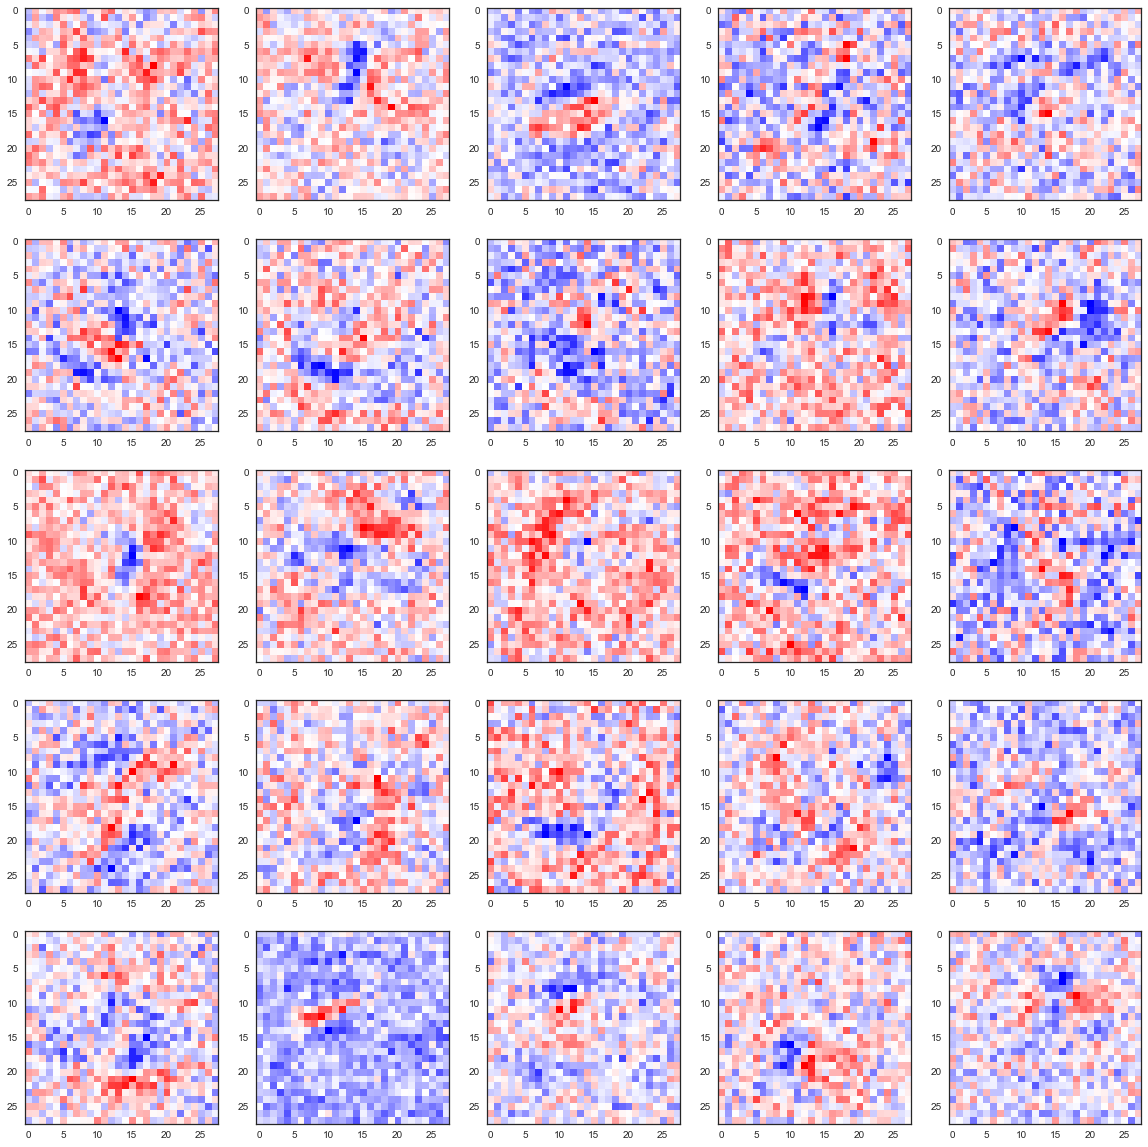

In [30]:
show_param_first_layer()

## Capacity control and overfitting

ANNs often have an enormous number of parameters: great risk of overfitting.

Strategies to prevent overfitting

- More data! Or use **data augmentation** to generate variations on the training data, exploiting symmetries.
- Limit number of neurons
- **Early stopping**
- Use regularization on the weights $L_1$ or $L_2$ regularization
- **Dropout** regularization
- Taking **ensembles** of different networks
- Creating invariants to certain transformations: e.g. **convolutional** ANNs

### Data augmentation

Expanding the training set with transformed versions of the data (e.g. rotations and translations of images).

A simple way of incorporating prior knowlegde in your models!

In [31]:
from skimage.transform import rotate

In [45]:
def demonstrate_rotation():

    im = mnist.train.images[8].reshape((28, 28))
    im_rot = rotate(im, angle=np.random.randn() * 10)

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 30))

    ax1.imshow(im)
    ax1.set_title('original')
    ax2.imshow(im_rot)
    ax2.set_title('rotated')
    ax3.imshow(im - im_rot, cmap='bwr')
    ax3.set_title('difference')

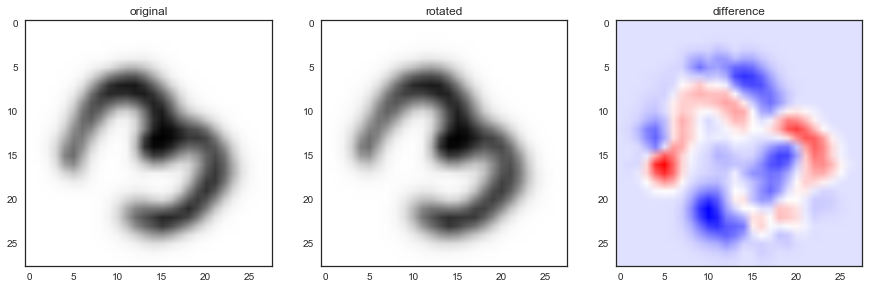

In [46]:
demonstrate_rotation()

In [34]:
def augment_by_rotation(X, r=5):
    """
    Rotates a set of instances by a random amount
    """
    n, p = X.shape
    Xrot = np.zeros_like(X)
    for i in range(n):
        im = X[i].reshape((28, 28))
        im[:] = rotate(im, angle=np.random.randn() * r)
        Xrot[i, :] = im.flatten()
    return Xrot

In [35]:
sess.run(tf.initialize_all_variables())

In [36]:
for i in range(5000):  # train for 1000 training steps
    batch = mnist.train.next_batch(100)  # take 500 instances in each step
    train_step.run(feed_dict={x: augment_by_rotation(batch[0], 10),
                              y_: batch[1]})

In [37]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9292


### Preventing overfitting

For large neural networks, overfitting is possible. We show this on a toy classification problem.

In [38]:
# simple classification example

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
#X, y = make_moons(noise=0.35, random_state=0, n_samples=200)
X, y = make_circles(noise=0.3, factor=0.5, random_state=0, n_samples=400)
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.75)

h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cm = plt.cm.RdBu

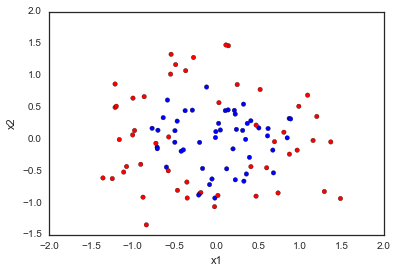

In [39]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.xlabel('x1')
plt.ylabel('x2')

In [40]:
    def plot_db(f, ax):
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        Z = f.eval(feed_dict={x : np.c_[xx.ravel(), yy.ravel()]})
        
        score = np.mean((f.eval(feed_dict={x : X_test}) > 0.5).ravel() == y_test)
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)
        
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')

In [41]:
x = tf.placeholder(tf.float32, shape=[None, 2])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

In [42]:
def train_network(n_hidden=10, n_steps = 100, reg=1e-4):
    train_accuracy = []
    test_accuracy = []
    # first layer
    W1, b1 = weight_variable([2, n_hidden]), bias_variable([n_hidden])
    a1 = tf.matmul(x, W1) + b1
    z1 = tf.tanh(a1)

    W2, b2  = weight_variable([n_hidden, 1]), bias_variable([1])
    a2 = tf.matmul(z1, W2) + b2
    f = 1 / (1 + tf.exp(-a2))
    loss = - y_ * tf.log(f) - (1 - y_) * tf.log(1 - f)
    
    # tiny bit of regularization
    for theta in [W1, W2, b1, b2]:
        loss += reg * tf.reduce_sum(tf.square(theta))
    
    train_step = tf.train.MomentumOptimizer(0.01, 0.70).minimize(loss)
    
    sess.run(tf.initialize_all_variables())
    for i in range(n_steps):
        train_step.run(feed_dict={x: X_train,
                              y_: y_train.reshape((-1, 1))})
        test_accuracy += [np.mean((f.eval(feed_dict={x : X_test}) > 0.5).ravel() == y_test)]
        train_accuracy += [np.mean((f.eval(feed_dict={x : X_train}) > 0.5).ravel() == y_train)]
    return f, train_accuracy, test_accuracy

#### Effect of number of neurons

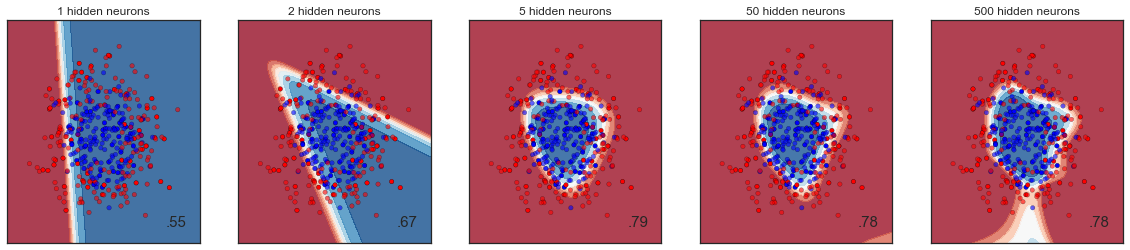

In [47]:
fig, axes = plt.subplots(ncols=5, figsize=(20, 4))

for i, n_hidden in enumerate([1, 2, 5, 50, 500]):
    f, train_accuracy, test_accuracy = train_network(n_hidden=n_hidden,
                                                     n_steps = 1000)
    plot_db(f, axes[i])
    axes[i].set_title('{} hidden neurons'.format(n_hidden))

### Early stopping

Stopping the training before the optimization algorithm has converged also has a regularization effect.

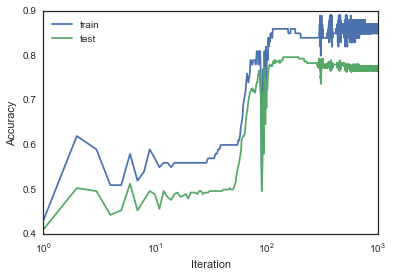

In [49]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(train_accuracy)+1),
        train_accuracy, label='train')
ax.plot(np.arange(1, len(test_accuracy)+1),
        test_accuracy, label='test')
ax.semilogx()
ax.legend(loc=0)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Iteration')

### Dropout regularization

During training: randomly drop a large number of neurons in each step.

Decorrelates neurons, strong regularization effect!

![](Figures/dropout.jpeg)

## Conclusions

- Artificial neural networks are very powerful learning algorithms for many problems
- Very flexible for different problems, also compact!
- Choosing topology, optimization... challenging: **engineering**.
- Implementation not too difficult in TensorFlow (or similar software).